# Data Normalization & Feature Sets
In this notebook we will take our data gathered from **1_downloading_data.ipynb** and conduct the following: 
* Create a **pandas df**
* Add **27 features** represented as a column for each utilizing: https://github.com/mrjbq7/ta-lib
* Add **normalized/stationary close** as the **28th feature** 
* Create a new **pandas df** with **28 total columns** & **n rows = time series** 
* Save our new **pandas df** as a **csv** within the same directory

### 28 feature set
```python
# tuple: first value = parameters, second value = features
features = {
    tanh(stationary(close)): (0, 1),
    volume: (0, 1),
    RSI: ([15,20,25,30], 4),
    SMA: ([15,20,25,30], 4),
    MACD: ([[26,12],[28,14],[30,16]], 3),
    MACD_Trigger: ([[9,26,12],[10,28,14],[11,30,16]], 3),
    William_R: ([14,18,22], 3),
    Stochastic_Oscillator: ([14,18,22], 3),
    Ultimate_Oscillator: ([[7,14,28],[8,16,22],[9,18,36]], 3),
    MFI: ([14,18,22], 3)
}
```

Once our new **pandas df** is created, we will then conduct a **sliding window** approach to create our images. This will be conducted in **notebook 3** 

## Oanda Error / Bug 
There seems to be a small *bug* when pulling data from **Oanda**. When you run **1_downloading_data.ipynb**, you may have put a date range such as: (2019,2,17) to (2019,3,10) 

For some reason, **Oanda** will then return that data with a new range set back a date. The data you wanted to pull was still pulled, it just seems to display differently. 

Therefor to correct this error we add **one day** to our **date column** and then make that our index


### side note
Trading days are **Monday to Friday** thus if you pulled data and it's not represented a certain way (skipped days), it's because of weekends.

In [ ]:
# # Installing single dependency
# !brew install ta-lib
# !pip install TA-Lib

In [1]:
import pandas as pd
import numpy as np
import os
from ta import *
import time
from datetime import date
from datetime import datetime 
from datetime import timedelta

import talib
from talib import abstract
from talib import MA_Type

## Loading & Fixing Error

In [2]:
# listing csv files
os.listdir(f'{os.curdir}/data/raw') 

['GBP_USD_D_2019-02-27_2019-03-10.csv',
 'GBP_USD_D_2018-02-01_2019-02-01.csv',
 'GBP_USD_D_2005-04-01_2017-04-01.csv',
 'GBP_USD_D_2009-06-01_2018-06-01.csv',
 'GBP_USD_D_2000-04-01_2017-04-01.csv',
 '.ipynb_checkpoints']

In [3]:
# Change this value to the file you want
file = 'GBP_USD_D_2009-06-01_2018-06-01.csv'

In [4]:
# loading data
data_path = f'{os.curdir}/data/raw/{file}'
df = pd.read_csv(data_path, names=['time', 'complete', 'open', 'high', 'low', 'close', 'volume'])

"""THE FOLLOWING ASSUMED YOU HAVE USED OANDA API TO SCRAPE DATA"""
# converting time to datetime
df['time'] = pd.to_datetime(df['time'])

# correcting our error 
df['time'] = df['time'] + timedelta(days=1)

# setting time as our index
df.set_index('time',inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2670 entries, 2009-06-01 21:00:00 to 2018-06-01 21:00:00
Data columns (total 6 columns):
complete    2670 non-null bool
open        2670 non-null float64
high        2670 non-null float64
low         2670 non-null float64
close       2670 non-null float64
volume      2670 non-null int64
dtypes: bool(1), float64(4), int64(1)
memory usage: 127.8 KB


In [6]:
df.tail(3)

,complete,open,high,low,close,volume
time,,,,,,
2018-05-30 21:00:00,True,1.32461,1.33078,1.32423,1.32830,80504
2018-05-31 21:00:00,True,1.32902,1.33484,1.32773,1.32962,78392
2018-06-01 21:00:00,True,1.32974,1.33618,1.32544,1.33473,76178


In [7]:
df.head(1)

,complete,open,high,low,close,volume
time,,,,,,
2009-06-01 21:00:00,True,1.61959,1.6498,1.6162,1.6444,99711


## Features
Now we will create a new df with the features we want. We will first add our features and then add ```tanh(stationary(close))```. Once we have all features we will create a ```final_df``` containing just **28 columns** each column with a specific feature & arrange them accordingly. 

In [8]:
# Making copy
f_df = df.copy()

In [9]:
"""
RSI
Parameters = [15, 20, 25, 30]
"""
f_df['RSI_15'] = talib.RSI(f_df['close'], timeperiod=15)
f_df['RSI_20'] = talib.RSI(f_df['close'], timeperiod=20)
f_df['RSI_25'] = talib.RSI(f_df['close'], timeperiod=25)
f_df['RSI_30'] = talib.RSI(f_df['close'], timeperiod=30)

In [10]:
"""
SMA
Parameters = [15, 20, 25, 30]
"""
f_df['SMA_15'] = talib.SMA(f_df['close'], timeperiod=15)
f_df['SMA_20'] = talib.SMA(f_df['close'], timeperiod=20)
f_df['SMA_25'] = talib.SMA(f_df['close'], timeperiod=25)
f_df['SMA_30'] = talib.SMA(f_df['close'], timeperiod=30)

In [11]:
"""
MACD
Parameters = [[26, 12], [28, 14], [30, 16]]
"""
macd_26_12 , _, __ = talib.MACD(f_df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
macd_28_14 , _, __ = talib.MACD(f_df['close'], fastperiod=14, slowperiod=28, signalperiod=9)
macd_30_16 , _, __ = talib.MACD(f_df['close'], fastperiod=16, slowperiod=30, signalperiod=9)

f_df['MACD_26_12'] = macd_26_12
f_df['MACD_28_14'] = macd_28_14
f_df['MACD_30_16'] = macd_30_16

In [12]:
"""
MACD Histogram 
Parameters = [[9, 26, 12], [10, 28, 14], [11, 30, 16]]
"""
macd_H_9_26_12 , _, __ = talib.MACD(f_df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
macd_H_10_28_14 , _, __ = talib.MACD(f_df['close'], fastperiod=14, slowperiod=28, signalperiod=10)
macd_H_11_30_16 , _, __ = talib.MACD(f_df['close'], fastperiod=16, slowperiod=30, signalperiod=11)

f_df['MACD_H_9_26_12'] = macd_H_9_26_12
f_df['MACD_H_10_28_14'] = macd_H_10_28_14
f_df['MACD_H_11_30_16'] = macd_H_11_30_16

In [13]:
"""
William_R
Parameters = [14, 18, 22]
"""
f_df['William_R_14'] = talib.WILLR(f_df['high'], f_df['low'], f_df['close'], timeperiod=14)
f_df['William_R_18'] = talib.WILLR(f_df['high'], f_df['low'], f_df['close'], timeperiod=18)
f_df['William_R_22'] = talib.WILLR(f_df['high'], f_df['low'], f_df['close'], timeperiod=22)

In [14]:
"""
Stochastic Oscillator
Parameters = [14, 18, 22]
"""
def stoch_osc(df_, n_days):
    """
    df_: the dataframe we will run through 
    n_days: size of our window or 'timeperoid'
    
    Assumes:
        column_names = ['close', 'low', 'high']
    """
    
    # Change these values if you have changed the column values
    closes = df_['close']
    lowest_values = df_['low'].rolling(n_days).min()
    highest_values = df_['high'].rolling(n_days).max()
    
    # Calculating stochastic value of indicator
    k = ((closes - lowest_values) / (highest_values - lowest_values)) * 100
    
    return k
    
    
f_df['Stoch_14'] = stoch_osc(f_df, 14)
f_df['Stoch_18'] = stoch_osc(f_df, 18)
f_df['Stoch_22'] = stoch_osc(f_df, 22)

In [15]:
"""
Ultimate Oscillator
Parameters = [[7, 14, 28], [8, 16, 22], [9, 18, 36]]
"""
f_df['Ultimate_7_14_28'] = talib.ULTOSC(f_df['high'], f_df['low'], f_df['close'], timeperiod1=7, timeperiod2=14, timeperiod3=28)

f_df['Ultimate_8_16_22'] = talib.ULTOSC(f_df['high'], f_df['low'], f_df['close'], timeperiod1=8, timeperiod2=16, timeperiod3=22)

f_df['Ultimate_9_18_36'] = talib.ULTOSC(f_df['high'], f_df['low'], f_df['close'], timeperiod1=9, timeperiod2=18, timeperiod3=36)

In [16]:
"""
MFI (Money Flow Index)
Parameters = [14, 18, 22]
"""
f_df['MFI_14'] = talib.MFI(f_df['high'], f_df['low'], f_df['close'], f_df['volume'], timeperiod=14)
f_df['MFI_18'] = talib.MFI(f_df['high'], f_df['low'], f_df['close'], f_df['volume'], timeperiod=18)
f_df['MFI_22'] = talib.MFI(f_df['high'], f_df['low'], f_df['close'], f_df['volume'], timeperiod=22)

## Stationary Close & Tanh
We will now add our **tanh(stationary(close))** value
* Calculate First Difference
* Calculate those value through a non-linear tanh function 

This will allow for the closing prices to range between {-1,1}

In [17]:
stationary_close = np.tanh(f_df['close'].diff())
f_df['Stationary_Close'] = stationary_close

In [18]:
# Counting how many labels we have generated
c_count_buy = list()
c_count_sell = list()
for c in stationary_close.values:
    if c > 0:
        c_count_buy.append(c)
    else:
        c_count_sell.append(c)

print(f'buy: {len(c_count_buy)}')
print(f'sell: {len(c_count_sell)}')

buy: 1281
sell: 1389


In [19]:
# we need to trim this down to 28 with our wanted features
len(list(f_df.columns))

33

In [21]:
# datastore - final dataframe before converting into images
ds_df = f_df.copy()

In [22]:
# # Label Version One
# ds_df.drop(columns=['complete', 'open', 'high', 'low', 'close'],inplace=True)

# Label Version Two
ds_df.drop(columns=['complete', 'high', 'low'],inplace=True)

In [23]:
len(list(ds_df.columns))

30

In [24]:
# # VERSION 1 - Now we will rearrange them - this is to attempt to replicate whitepaper 
# new_order = ['Stationary_Close', 'volume', 'RSI_15', 'RSI_20', 'RSI_25', 'RSI_30', 'SMA_15', 'SMA_20', 'SMA_25', 'SMA_30', 'MACD_26_12', 'MACD_28_14', 'MACD_30_16', 'MACD_H_9_26_12', 'MACD_H_10_28_14', 'MACD_H_11_30_16', 'William_R_14', 'William_R_18', 'William_R_22', 'Stoch_14', 'Stoch_18', 'Stoch_22', 'Ultimate_7_14_28', 'Ultimate_8_16_22', 'Ultimate_9_18_36', 'MFI_14', 'MFI_18', 'MFI_22']


# VERSION 2 
new_order = ['Stationary_Close', 'volume', 'RSI_15', 'RSI_20', 'RSI_25', 'RSI_30', 'SMA_15', 'SMA_20', 'SMA_25', 'SMA_30', 'MACD_26_12', 'MACD_28_14', 'MACD_30_16', 'MACD_H_9_26_12', 'MACD_H_10_28_14', 'MACD_H_11_30_16', 'William_R_14', 'William_R_18', 'William_R_22', 'Stoch_14', 'Stoch_18', 'Stoch_22', 'Ultimate_7_14_28', 'Ultimate_8_16_22', 'Ultimate_9_18_36', 'MFI_14', 'MFI_18', 'MFI_22', 'open', 'close']

ds_df = ds_df[new_order]

In [25]:
# Normalizing volume
from sklearn.preprocessing import RobustScaler

transformer = RobustScaler().fit(np.array(ds_df['volume'].values).reshape(-1,1))
transformer
RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)
new_vol = transformer.transform(np.array(ds_df['volume'].values).reshape(-1,1))

In [26]:
df['new_vol'] = new_vol

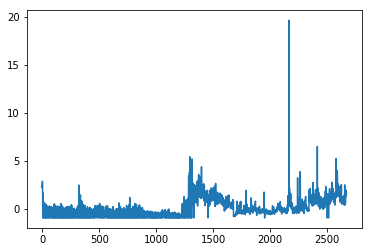

In [295]:
plt.plot(df['new_vol'].values)

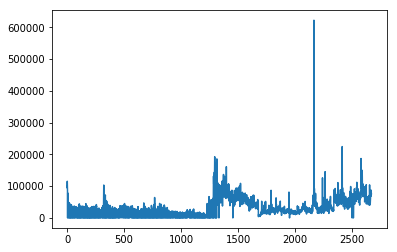

In [296]:
plt.plot(df['volume'].values)

In [27]:
# replacing values
ds_df['volume'] = df['new_vol']

In [28]:
# #VERSION 1 - saving datastore to our post_processing directory
# path = f'{os.curdir}/data/post_processing'
# ds_df.to_csv(f'{path}/datastore.csv',index=True)

# VERSION 2 
#saving datastore to our post_processing directory
path = f'{os.curdir}/data/post_processing'
ds_df.to_csv(f'{path}/datastore_v2.csv',index=True)